**Installing Libraries**

In [ ]:
!pip install mmh3

     |████████████████████████████████| 51kB 2.5MB/s 


**Importing Modules**

In [ ]:
import pandas as pd
from IPython.display import display, HTML
import random
import statistics
import mmh3
import numpy as np
import sys
from collections import defaultdict
import matplotlib.pyplot as plt

**Importing Data** <br>
We first import the training data for the frequency of words in given documents. Then a data frame is created by splitting the values into columns and deleting the first column for docID. A new dictionary is created to store the frequencies of each word appearing in all documents.

In [ ]:
train_path = 'https://raw.githubusercontent.com/kushagra-18110091/http_test/main/train.data'
data = pd.read_csv(train_path)
data = data.iloc[:, 0].str.split(pat=" ", expand=True)
data = data.drop(data.columns[[0]], axis=1)

uniq_index = pd.unique(data.iloc[:,0])
result = {}

for i in range(len(uniq_index)):
  result[uniq_index[i]] = int(0)

for i in range(len(data)):
  result[data.iloc[i,0]] = int(result[data.iloc[i,0]]) + int(data.iloc[i,1])

data.columns = ['wordIdx', 'count']

**Creating Query Set** <br>
We create a data frame for query set by sorting the previously created dictionary in descending order of frequencies and then sample 100 entries from it.

In [ ]:
query = pd.DataFrame(result.items(), columns=['WordIdx', 'Count'])
query = query.sort_values('Count', ascending=False)
query = query.iloc[0:1000,:]
query = query.sample(n=100)

query = query.to_numpy()
data = data.to_numpy()

**Count Min Sketch** <br>
The class contains three functions `__init__`, `addCM` and `queryCM`. <br><ul>
<li> The `__init__` function initialzes the `w` and `d` values and creates an array to store the frequencies calculated by the count min sketch. <br> 
<li> The `addCM` function adds the element, count times, to the array by calculating the array index using hash values.
<li> The `queryCM` function queries the sketch to return the frequency computed by the sketch for an element. 

In [ ]:
class CMSketch:
    def __init__(self,w,d):
        self.w = w
        self.d = d
        self.arrayCM = np.zeros([self.w, self.d],dtype=int)
        self.seed_hi = np.random.randint(d, size = w)

    def addCM(self,id,count):
        for i in range(self.w):
            hi = mmh3.hash(id,self.seed_hi[i])%(self.d)
            self.arrayCM[i][hi] += count
        return

    def queryCM(self,id):
        countArray = []
        for i in range(self.w):
            hi = mmh3.hash(id,self.seed_hi[i])%(self.d)
            countArray.append(self.arrayCM[i][hi])
        return min(countArray)


**Querying Count Min Sketch** <br>
For each value of `d`, Count Min Sketch is initialized and the values from the data stream are added. The average relative error is then calculated by querying the sketch.

In [ ]:
CMError = []

for d in [20,40,100,200,400]:
  CMS = CMSketch(5,d)

  for i in range(len(data)):
    CMS.addCM(data[i][0],int(data[i][1]))

  sum  = 0

  for i in range(100):
    sum += abs(CMS.queryCM(query[i][0]) - query[i][1])/query[i][1]

  CMError.append(sum/100)

**Count Sketch** <br>
The class contains three functions `__init__`, `addCS` and `queryCS`. <br><ul>
<li> The `__init__` function initialzes the `w` and `d` values and creates an array to store the frequencies calculated by the count sketch. <br> 
<li> The `addCS` function adds the element, count times, to the array by calculating the array index using hash values and sign value for each index and element.
<li> The `queryCS` function queries the sketch to return the frequency computed by the sketch for an element. 

In [ ]:
class CSketch:
    def __init__(self,w,d):
        self.w = w
        self.d = d
        self.arrayCS = np.zeros([self.w, self.d],dtype=int)
        self.seed_hi = np.random.randint(d, size = w)
        self.seed_gi = np.random.randint(d, size = w)

    def addCS(self,id,count):
        for i in range(self.w):
            hi = mmh3.hash(id,self.seed_hi[i])%(self.d)
            sign = 1
            if(mmh3.hash(id,self.seed_gi[i])%2 == 0):
                sign = -1
            self.arrayCS[i][hi]+= count*sign
        return

    def queryCS(self,id):
        countArray = []
        for i in range(self.w):
            hi = mmh3.hash(id,self.seed_hi[i])%(self.d)
            sign = 1
            if(mmh3.hash(id,self.seed_gi[i])%2 == 0):
                sign = -1
            countArray.append(sign*self.arrayCS[i][hi])
        return statistics.median(countArray)

**Querying Count Sketch** <br>
For each value of `d`, Count Sketch is initialized and the values from the data stream are added. The average relative error is then calculated by querying the sketch.

In [ ]:
CSError = []

for d in [20,40,100,200,400]:
  CS = CSketch(5,d)

  for i in range(len(data)):
    CS.addCS(data[i][0],int(data[i][1]))

  sum = 0
  for i in range(100):
    sum += abs(CS.queryCS(query[i][0]) - query[i][1])/query[i][1]

  CSError.append(sum/100)

**Misra Gries Sketch** <br>
The class contains three functions `__init__`, `addMG` and `queryMG`. <br><ul>
<li> The `__init__` function initialzes the `K` value and creates a dictionary to store the frequencies calculated by the misra gries sketch. <br> 
<li> The `addMG` function adds the element with count, to the dictionary if not present. Otherwise the count of the element is increased count times. If the number of elements in dictionary are greater than `K`, the count of each element is decreased count times and all elements with frequencies less than 0 are deleted.
<li> The `queryMG` function queries the sketch to return the frequency computed by the sketch for an element. 

In [ ]:
class MGSketch:
    def __init__(self,K):
        self.K = K
        self.countMG = defaultdict(int)

    def addMG(self,id,count):
      if len(self.countMG.keys()) < self.K:
          self.countMG[id] += count
        
      elif id in self.countMG:
          self.countMG[id] += count

      else:
          for key in list(self.countMG.keys()):
              self.countMG[key] -= count
              if self.countMG[key] <= 0:
                del self.countMG[key]
      return

    def queryMG(self,id):
        if(self.countMG[id] != 0):    
          return self.countMG[id]
        else:
          return 0

**Querying Misra Gries Sketch** <br>
For each value of `K`, Misra Gries Sketch is initialized and the values from the data stream are added. The average relative error is then calculated by querying the sketch.

In [ ]:
MGError = []

for K in [100,200,500,1000,2000]:
  MG = MGSketch(K)

  for i in range(len(data)):
    MG.addMG(data[i][0],int(data[i][1]))

  sum = 0

  for i in range(100):
    sum += abs(MG.queryMG(query[i][0]) - query[i][1])/query[i][1]
  
  MGError.append(sum/100)

**Calculating Relative Errors for each K**<br>

In [ ]:
result = []

for i in range(0,5):
  errors = []
  errors.append(CMError[i])
  errors.append(CSError[i])
  errors.append(MGError[i])
  result.append(errors)

print("Relative errors for the sketches for K values in [100,200,400,1000,2000]")
result = pd.DataFrame(result, columns=["Count Min Sketch","Count Sketch","Misra Gries Sketch"])
display(HTML(result.to_html()))

Relative errors for the sketches for K values in [100,200,400,1000,2000]


,Count Min Sketch,Count Sketch,Misra Gries Sketch
0,148.678827,63.212568,0.998396
1,62.666012,9.456200,0.991614
2,21.014037,4.712923,0.953058
3,9.017712,2.291099,0.887774
4,3.805000,1.228228,0.754445


**Plotting the Results**<br>

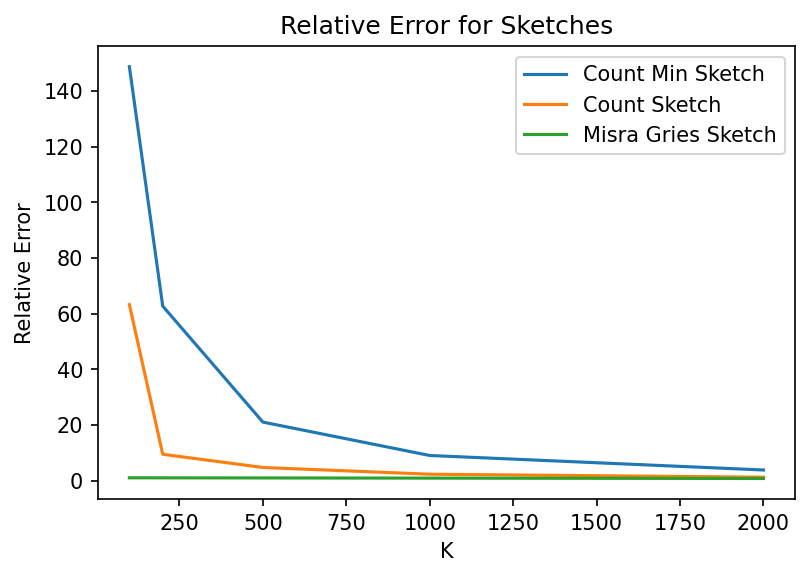

In [ ]:
x = [100,200,500,1000,2000]

plt.figure(dpi=150)
plt.plot(x, CMError, label = "Count Min Sketch")
plt.plot(x, CSError, label = "Count Sketch")
plt.plot(x, MGError, label = "Misra Gries Sketch")

plt.xlabel('K')
plt.ylabel('Relative Error')
  
plt.title('Relative Error for Sketches')
plt.legend()
  
plt.show()

**Binary Search Function**<br> 

In [ ]:
def find_error(sketch):
  low = 1000
  high = 250000
  while(low <= high):
    mid = low + (high - low)/2
    error = 0

    if (sketch == "CMS"):
      CMS = CMSketch(5,int(mid/5))

      for i in range(len(data)):
        CMS.addCM(data[i][0],int(data[i][1]))

      for i in range(100):
        error += abs(CMS.queryCM(query[i][0]) - query[i][1])/query[i][1]

    elif (sketch == "CS"):
      CS = CSketch(5,int(mid/5))

      for i in range(len(data)):
        CS.addCS(data[i][0],int(data[i][1]))

      for i in range(100):
        error += abs(CS.queryCS(query[i][0]) - query[i][1])/query[i][1]

    elif (sketch == "MG"):
      MG = MGSketch(mid)

      for i in range(len(data)):
        MG.addMG(data[i][0],int(data[i][1]))

      for i in range(100):
        error += abs(MG.queryMG(query[i][0]) - query[i][1])/query[i][1]

    if (error <= 1.5 and error >= 0.85):
      return mid
    elif (error > 1.05):
      low = mid + 1
    elif (error < 0.85):
      high = mid - 1

**Calculating Minimum K for less than 1% Error**<br>

In [ ]:
error_values = []
result = []
error_values.append(find_error("CMS"))
error_values.append(find_error("CS"))
error_values.append(find_error("MG"))
result.append(error_values)

print("K values such that the relative error is less than 1%")
result = pd.DataFrame(result, columns=["Count Min Sketch","Count Sketch","Misra Gries Sketch"])
display(HTML(result.to_html()))

K values such that the relative error is less than 1%


,Count Min Sketch,Count Sketch,Misra Gries Sketch
0,78812.125,125500.0,32124.25
